In [1]:
import numpy as np
import pandas as pd
import glob, os, vcf, warnings, shutil, subprocess, re
from Bio import Seq, SeqIO
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy
import panel as pn
# pn.extension('ipywidgets')
# pn.extension()

h37Rv_path = "/n/data1/hms/dbmi/farhat/Sanjana/H37Rv"
h37Rv_seq = SeqIO.read(os.path.join(h37Rv_path, "GCF_000195955.2_ASM19595v2_genomic.gbff"), "genbank")
h37Rv_genes = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_genes_v4.csv"))
h37Rv_regions = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_v4.csv"))

h37Rv_coords = pd.read_csv(os.path.join(h37Rv_path, "h37Rv_coords_to_gene.csv"))
h37Rv_coords_dict = dict(zip(h37Rv_coords["pos"].values, h37Rv_coords["region"].values))

df_TRUST_pids_samples = pd.read_csv("/n/data1/hms/dbmi/farhat/rollingDB/TRUST/clinical_data/combined_patient_WGS_data.csv").dropna(subset='pid')

In [ ]:
# check all the taxa that were included. Were parent taxa included? Children were definitely

In [2]:
df_TRUST_new = pd.read_csv("./processed_data/TRUST_DATA_2025-05-12_1129.cleaned.wide.csv")

In [6]:
df_TRUST_new.columns[df_TRUST_new.columns.str.contains('totaltrust_enrollm')]

Index(['trust_after_total_totaltrust_enrollm', 'total_pid_totaltrust_enrollm',
       'total_enrollment_dt_totaltrust_enrollm',
       'pos_cul_total_totaltrust_enrollm', 'bmc_staff_totaltrust_enrollm',
       'bmc_staff_dt_totaltrust_enrollm',
       'trust_enrollment_complete_totaltrust_enrollm',
       'audit_total_totaltrust_enrollm', 'audit_cat_totaltrust_enrollm',
       'cesd_total_totaltrust_enrollm', 'cesd_bin_totaltrust_enrollm',
       'household_hunger_totaltrust_enrollm',
       'household_hunger_cat_totaltrust_enrollm',
       'household_hunger_bin_totaltrust_enrollm',
       'dudit_total_totaltrust_enrollm',
       'dudit_total_discrete_totaltrust_enrollm'],
      dtype='object')

In [21]:
df_WGS = pd.read_csv("/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_summary.csv")

In [22]:
df_WGS

,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,Lineage,Freschi_Lineage_1,Freschi_Lineage_2,Culture_Mixed_Infection
0,MFS-1,0.37,307.773105,314.0,98.643759,98.486308,0.011212,2.2.1.1,2.2.1.1.1,"beijing,mungi","lin2.2.1,pacific_RD150",NaN,2,2.2.1.1.1,NaN,0
1,MFS-10,0.37,332.305094,338.0,99.074517,98.966640,0.009122,4.3.2.1,4.2.1.2.1.1.i1,lam,NaN,4.3/LAM,4,4.2.1.2.1.1.i1,NaN,0
2,MFS-100,0.77,267.979292,273.0,98.973191,98.840403,0.008850,4.4.1.1,4.2.1.2.2.1.1,"stype,indo_oceanic",NaN,4,4,4.2.1.2.2.1.1,NaN,0
3,MFS-101,0.73,300.620813,307.0,98.987835,98.836595,0.008316,4.4.1.1,4.2.1.2.2.1.1,"stype,indo_oceanic",NaN,4,4,4.2.1.2.2.1.1,NaN,0
4,MFS-102,0.91,276.773151,282.0,98.829024,98.696394,0.018669,4.1.1.3,4.1.i1.2.1,xtype,NaN,4,4,4.1.i1.2.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,MFS-95,0.76,345.375614,354.0,99.028750,98.888731,0.019837,4.1.1.3,4.1.i1.2.1,xtype,NaN,4,4,4.1.i1.2.1,NaN,0
778,MFS-96,0.53,376.949171,384.0,99.018210,98.879936,0.020201,4.1.1.3,4.1.i1.2.1,xtype,NaN,4,4,4.1.i1.2.1,NaN,0
779,MFS-97,0.78,325.623465,333.0,98.534545,98.392826,0.010201,2.2.1.1,2.2.1.1.1,"beijing,mungi","lin2.2.1,pacific_RD150",NaN,2,2.2.1.1.1,NaN,0
780,MFS-98,0.52,371.939378,380.0,98.918652,98.799261,0.018668,4.1.1.3,4.1.i1.2.1,xtype,NaN,4,4,4.1.i1.2.1,NaN,0


In [24]:
def compute_BAM_depth_metrics(df, sample_id_col, run_id_col, out_dir=None):

    df_BAM_depths = pd.DataFrame(columns = [sample_id_col, run_id_col, 'Mean_Depth', 'Median_Depth', 'Prop_20x', 'Prop_10x'])
    idx = 0

    if out_dir is None:
        out_dir = "/n/data1/hms/dbmi/farhat/rollingDB/genomic_data"
    
    for i, name in enumerate(df[sample_id_col].values):

        run_ids = np.sort(df.query(f"{sample_id_col}==@name")[run_id_col].values)
    
        if os.path.isfile(f"{out_dir}/{name}/bam/{name}.depth.tsv.gz"):
    
            df_depth = pd.read_csv(f"{out_dir}/{name}/bam/{name}.depth.tsv.gz", compression='gzip', header=None, sep='\t')
        
            pass_props = []
            
            for k, col in enumerate(df_depth.columns[2:]):

                mean_depth = df_depth[col].mean()
                median_depth = df_depth[col].median()
                prop_20x = len(df_depth.loc[df_depth[col] >= 20]) / len(df_depth)
                prop_10x = len(df_depth.loc[df_depth[col] >= 10]) / len(df_depth)

                df_BAM_depths.loc[idx, :] = [name, run_ids[k], mean_depth, median_depth, prop_20x, prop_10x]
                idx += 1
    
        else:
            print(f"No depth file for {name}")
    
        if i % 1000 == 0:
            print(i)
    
    return df_BAM_depths



def extract_lineages(df, name_col, out_dir=None):

    df_add = []

    if out_dir is None:
        out_dir = "/n/data1/hms/dbmi/farhat/rollingDB/genomic_data"
    
    for sample in df[name_col].unique():

        if os.path.isfile(f"{out_dir}/{sample}/lineage/fast_lineage_caller_output.txt"):
        
            F2 = float(pd.read_csv(f"{out_dir}/{sample}/lineage/F2_Coll2014.txt", sep='\t', header=None)[0].values[0])
    
            df_flc = pd.read_csv(f"{out_dir}/{sample}/lineage/fast_lineage_caller_output.txt", sep='\t')
    
            df_flc['ROLLINGDB_ID'] = df_flc['Isolate'].str.split('_').str[0]
            
            for col in df_flc.columns:
                if col not in ['Isolate', 'ROLLINGDB_ID']:
                    df_flc.rename(columns={col: col.capitalize()}, inplace=True)
    
            df_flc['Coll2014'] = df_flc['Coll2014'].str.replace('lineage', '')
            df_flc['F2'] = F2
    
            if df_flc['Coll2014'].values[0][0].isnumeric():
                df_flc['Lineage'] = df_flc['Coll2014'].values[0][0]
            else:
                df_flc['Lineage'] = df_flc['Coll2014'].values[0]
            
            df_add.append(df_flc)
    
    df_add = pd.concat(df_add)
    del df_add['Isolate']
    
    return df_add

In [23]:
df_WGS_contam_control = df_WGS[['SampleID', 'Kraken_Unclassified_Percent']]

In [ ]:
df_WGS_contam_control

In [38]:
df_BAM_depth[['SampleID']]

,SampleID,SampleID
0,MFS-1,MFS-1
1,MFS-10,MFS-10
2,MFS-100,MFS-100
3,MFS-101,MFS-101
4,MFS-102,MFS-102
...,...,...
748,MFS-95,MFS-95
749,MFS-96,MFS-96
750,MFS-97,MFS-97
751,MFS-98,MFS-98


In [40]:
df_BAM_depth.columns = ['SampleID', 'Drop', 'Mean_Depth', 'Median_Depth', 'Prop_20x', 'Prop_10x']

In [41]:
del df_BAM_depth['Drop']

In [35]:
df_WGS_contam_control = df_WGS_contam_control.merge(df_lineages.rename(columns={'ROLLINGDB_ID': 'SampleID'}), how='left')

In [34]:
df_WGS_contam_control.shape

(782, 2)

In [43]:
df_WGS_contam_control = df_WGS_contam_control.merge(df_BAM_depth, on='SampleID', how='left')

In [46]:
df_WGS_contam_control.rename(columns={'Kraken_Unclassified_Percent': 'Kraken_Custom_DB_Unclassified_Percent'}, inplace=True)

In [52]:
assert len(df_WGS_contam_control.query("Kraken_Custom_DB_Unclassified_Percent > 20").dropna(subset='Median_Depth')) == 0
assert len(df_WGS_contam_control.loc[pd.isnull(df_WGS_contam_control['F2'])].query("Kraken_Custom_DB_Unclassified_Percent <= 20")) == 0


In [49]:
df_WGS_contam_control.sort_values('Kraken_Custom_DB_Unclassified_Percent')

,SampleID,Kraken_Custom_DB_Unclassified_Percent,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,F2,Lineage,Mean_Depth,Median_Depth,Prop_20x,Prop_10x
640,MFS-750,0.27,4.4.1.1,4.2.1.2.2.1.1,stype,NaN,4,0.008676,4,238.118858,235.0,0.99064,0.991952
638,MFS-748,0.28,4.3.2.1,4.2.1.2.1.1.i1,lam,NaN,4.3/LAM,0.010162,4,311.916435,316.0,0.990228,0.991131
684,MFS-792,0.29,4.3.3,4.2.1.2.1.1.i4.1,lam,NaN,4.3/LAM,0.006688,4,373.974977,377.0,0.989667,0.990465
619,MFS-730,0.29,4.3.3,4.2.1.2.1.1.i4.1,lam,NaN,4.3/LAM,0.006041,4,309.975184,313.0,0.988213,0.989128
688,MFS-796,0.31,3,3.1.1,"east_african_indian,ghana,mungi",NaN,NaN,0.008749,3,264.997745,269.0,0.991584,0.992546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,MFS-494,99.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,MFS-496,99.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,MFS-498,99.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,MFS-501,99.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_WGS_contam_control.to_csv("~/TRUST_data/WGS_data.csv", index=False)

In [25]:
df_lineages = extract_lineages(df_WGS_contam_control, 'SampleID', out_dir="/n/data1/hms/dbmi/farhat/Sanjana/TRUST_lowAF")

In [26]:
# df_BAM_depth = compute_BAM_depth_metrics(df_WGS_contam_control, 'SampleID', 'SampleID', out_dir="/n/data1/hms/dbmi/farhat/Sanjana/TRUST_lowAF")

0
No depth file for MFS-179
No depth file for MFS-183
No depth file for MFS-304
No depth file for MFS-422
No depth file for MFS-423
No depth file for MFS-425
No depth file for MFS-451
No depth file for MFS-453
No depth file for MFS-477
No depth file for MFS-490
No depth file for MFS-491
No depth file for MFS-492
No depth file for MFS-493
No depth file for MFS-494
No depth file for MFS-495
No depth file for MFS-496
No depth file for MFS-497
No depth file for MFS-498
No depth file for MFS-499
No depth file for MFS-500
No depth file for MFS-501
No depth file for MFS-502
No depth file for MFS-503
No depth file for MFS-504
No depth file for MFS-505
No depth file for MFS-506
No depth file for MFS-507
No depth file for MFS-508
No depth file for MFS-78


In [14]:
df_TRUST_new[df_TRUST_new.columns[df_TRUST_new.columns.str.contains('totaltrust_enrollm')]].query("trust_after_total_totaltrust_enrollm==1")

,trust_after_total_totaltrust_enrollm,total_pid_totaltrust_enrollm,total_enrollment_dt_totaltrust_enrollm,pos_cul_total_totaltrust_enrollm,bmc_staff_totaltrust_enrollm,bmc_staff_dt_totaltrust_enrollm,trust_enrollment_complete_totaltrust_enrollm,audit_total_totaltrust_enrollm,audit_cat_totaltrust_enrollm,cesd_total_totaltrust_enrollm,cesd_bin_totaltrust_enrollm,household_hunger_totaltrust_enrollm,household_hunger_cat_totaltrust_enrollm,household_hunger_bin_totaltrust_enrollm,dudit_total_totaltrust_enrollm,dudit_total_discrete_totaltrust_enrollm
219,1,P0112,2021-10-05,0.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
254,1,P0001,2021-04-22,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
331,1,P0153,2021-11-24,0.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
333,1,CT0004,2022-07-27,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
346,1,P0002,2021-04-23,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
352,1,P0453,2022-09-08,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
359,1,P0492,2022-10-05,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
362,1,CT0007,2022-10-31,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
371,1,P0475,2022-09-22,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence
374,1,P0553,2022-11-29,1.0,Sue Kulkarni,2025-01-28,0,0,1,0,0,0,0,0,0,low risk/abstinence


In [18]:
df_WGS = pd.read_csv("")

NameError: name 'df_WGS' is not defined

# Generate BED file to subset the Freebayes VCF files for regions of interest first

In [2]:
# prpR = Rv1129c
regions_of_interest = ['Rv1129c', 'glpK', 'eccB3', 
                     'espR', 'espA', 'espK',
                     'bioF2', 'ponA1', 
                     'vapC2', 'Rv0302', # intergenic region between these two
                     'Rv0678',
                     'Rv0759c', 'Rv0760c', # intergenic region between these two
                     'PPE13',
                     'Rv1373',
                     'PE_PGRS25', # low empirical base pair recall
                     'lysX', 'infC', # intergenic region between these two
                     'wag22', # low empirical base pair recall
                     'Rv1894c',
                     'Rv2177c', 'aroG', # intergenic region between these two
                     'Rv2264c',
                     'lipR',
                     'PPE53', # low empirical base pair recall
                     'Rv3192',
                     'Rv3413c',
                     'B11', # small regulatory RNA
                    ]

print(f"{len(regions_of_interest)} regions of interest")

# check that they were all copied correctly
assert len(set(regions_of_interest) - set(h37Rv_regions.query("Locus in @regions_of_interest | Name in @regions_of_interest").Locus) - set(h37Rv_regions.query("Locus in @regions_of_interest | Name in @regions_of_interest").Name)) == 0

28 regions of interest


In [3]:
# 0-indexed half-open
df_BED_file = pd.DataFrame(columns = ['BEG', 'END'])
k = 0

In [4]:
# for the intergenic regions, extract the coordinates between the up- and downstream genes
# for espR, the homopolymeric tract is upstream of the gene
upstream_genes = ['vapC2', 'Rv0759c', 'lysX', 'Rv2177c', 'Rv3848']
downstream_genes = ['Rv0302', 'Rv0760c', 'infC', 'aroG', 'espR']

for i, up_gene in enumerate(upstream_genes):

    down_gene = downstream_genes[i]

    end_up_gene = h37Rv_regions.query("Name == @up_gene").Stop.values[0]
    start_down_gene = h37Rv_regions.query("Name == @down_gene").Start.values[0]

    # check
    assert end_up_gene < start_down_gene

    # leave end_up_gene as-is because it should be 0-indexed inclusive
    # subtract 1 from start_down_gene because we don't want the last one
    # if the next gene starts at position 100 (index 99), then we want to go up to but not include index 99, so the upper bound should be 99, meaning we include up to and including index 98
    df_BED_file.loc[k, :] = [end_up_gene, start_down_gene-1]
    k += 1

In [5]:
# but keep espR full ORF
regions_of_interest = list(set(regions_of_interest) - set(upstream_genes) - set(downstream_genes)) + ['espR']
len(regions_of_interest)

20

In [6]:
for gene in regions_of_interest:

    assert len(h37Rv_regions.query("Locus==@gene | Name==@gene")) == 1

    start, end = h37Rv_regions.query("Locus==@gene | Name==@gene")[['Start', 'Stop']].values[0]

    # start must be 0-indexed, so subtract 1
    # keep end as is because that index is excluded. If the gene runs from 1-100 in POS, then that would be 0-100 in BED file coordinates
    # which means take the 0th index (first position) up to the 99th index inclusive
    df_BED_file.loc[k, :] = [start - 1, end]
    k += 1

In [7]:
df_BED_file['CHROM'] = 'Chromosome'
df_BED_file.set_index('CHROM').to_csv("Mtb_low_frequency_variants/references/BED_files/phase_variation_ROI.bed", sep='\t')

In [10]:
exclude_BED = pd.read_csv("Mtb_low_frequency_variants/references/BED_files/RLC_Regions.Plus.LowPmapK50E4.H37Rv.bed", sep='\t', header=None)

# change chromosome name
exclude_BED[0] = 'Chromosome'

# extend by 50 bp on both sides
exclude_BED[1] -= 50
exclude_BED[2] += 50

exclude_BED.sort_values([1, 2]).to_csv("Mtb_low_frequency_variants/references/BED_files/exclude_regions_50bp.bed", sep='\t', header=None, index=False)

# Read in the Files through pyvCF and compute AF (script `01_write_annotated_variants_TSV.py`)

The AF in the VCF file is rounded, so compute it from AO / (AO + RO).

In [4]:
df_variants = []

for k, sample in enumerate(os.listdir("/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples")):

    fName = f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples/{sample}/{sample}.variants.csv"
    df = pd.read_csv(fName)        
    
    df['SampleID'] = sample
    df_variants.append(df)

    if k % 100 == 0:
        print(k)

df_variants = pd.concat(df_variants).reset_index(drop=True)

0
100
200
300
400
500
600
700


In [6]:
df_variants.SampleID.nunique()

753

In [10]:
df_variants = df_variants.merge(df_TRUST_pids_samples.dropna(subset='pid')[['pid', 'SampleID', 'F2', 'Coll2014', 'Lineage']], on='SampleID').set_index(['pid', 'SampleID']).reset_index()

F2_thresh = 0.03
df_variants.loc[df_variants['F2'] > F2_thresh, 'high_F2'] = 1
df_variants['high_F2'] = df_variants['high_F2'].fillna(0).astype(int)

In [12]:
df_variants.SampleID.nunique(), df_variants.pid.nunique()

(747, 418)

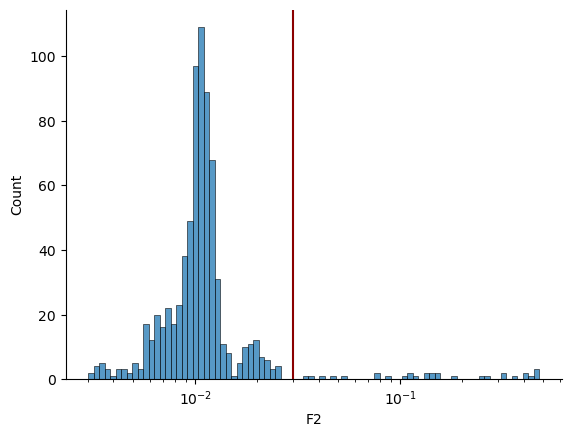

In [13]:
sns.histplot(data=df_variants.drop_duplicates('SampleID'),
             x='F2',
             log_scale=10
            )

plt.axvline(F2_thresh, color='darkred')
sns.despine()
plt.show()

In [14]:
df_variants.drop_duplicates("SampleID")['high_F2'].value_counts(dropna=False)

high_F2
0    717
1     30
Name: count, dtype: int64

In [8]:
# df_variants = df_variants.query("high_F2==0")

In [15]:
# does each patient have multiple WGS samples taken
df_variants['longitudinal_patient'] = df_variants.groupby('pid')['SampleID'].transform(lambda x: len(np.unique(x)) > 1).astype(int)
df_variants.drop_duplicates('SampleID').longitudinal_patient.value_counts()

longitudinal_patient
1    646
0    101
Name: count, dtype: int64

# Strand Bias Analysis

SRP And SAP are Phred-scaled probabilities, so convert them to error probabilities: $Q = -10\log(P)$, so $P = 10^{-Q/10}$

Not clear on how to use SRP, so just require that the alternative allele is supported by at least 1 forward and 1 reverse read for inclusion.

In [10]:
# these are upper bounds on the probability of observing the observed deviation between SRF and SRR or between SAF and SAR, given that the expected probability 
df_variants['SRP_prob'] = 10**(-df_variants['SRP']/10)
df_variants['SAP_prob'] = 10**(-df_variants['SAP']/10)

# when SRF = SRR = 0, there are no reads supporting the reference. If quality is 0, then the error probability is 1, which isn't true. They're actually NA
df_variants.loc[(df_variants['SRF']==0) | (df_variants['SRR']==0), 'SRP_prob'] = np.nan

# Low Frequency Variants

### Do Samples with Low-AF Variants (for single-ALT allele sites) tend to have higher F2?

In [11]:
def plot_F2_distribution_for_lowAF_variants(AF_max, num_support_each_direction):

    # use 0.05 as the minimum inclusive. Don't consider variants < 0.05 because they are likely just noise
    samples_with_lowAF_variants = df_variants.query("AF >= 0.05 & AF <= @AF_max & SAF >= @num_support_each_direction & SAR >= @num_support_each_direction & SAP_prob > 0.05").SampleID.unique()
    samples_without_lowAF_variants = list(set(df_variants.SampleID) - set(samples_with_lowAF_variants))
    
    if 'LowAF_Sample' in df_variants.columns:
        del df_variants['LowAF_Sample']
        
    df_variants['LowAF_Sample'] = df_variants['SampleID'].isin(samples_with_lowAF_variants).astype(int)

    fig, ax = plt.subplots()
    
    sns.histplot(data=df_variants.drop_duplicates('SampleID'),
                  hue='LowAF_Sample',
                  x='F2',
                 log_scale=10,
                 common_norm=False,
                 stat='probability',
                 multiple='dodge',
                 ax=ax
                 )

    test_stat, pval = st.ks_2samp(np.log(df_variants.drop_duplicates('SampleID').query("LowAF_Sample==0").F2),
                                  np.log(df_variants.drop_duplicates('SampleID').query("LowAF_Sample==1").F2),
                                  alternative='two-sided'
                                 )
    
    ax.set_xlim(0, np.round(np.max(df_variants.F2), 1))
    ax.set_title(f"AF ∈ [0.05, {np.round(AF_max, 2)}], Supporting Reads in Each Direction = {num_support_each_direction}\n"
                 f"{len(samples_with_lowAF_variants)}/{df_variants.SampleID.nunique()} samples have low-frequency variants in the regions of interest\n"
                 f"KS p-value = {pval}", fontsize=9)
    
    sns.despine()
    return fig

In [12]:
# AF_max_slider = pn.widgets.FloatSlider(name='AF Maximum', start=0.10, end=0.75, step=0.05, value=0.10)
# num_reads_slider = pn.widgets.DiscreteSlider(name='Number of Reads Supporting each direction', options=list(np.arange(1, 11, 1)), value=2)

# plot = pn.bind(plot_F2_distribution_for_lowAF_variants, 
#                AF_max=AF_max_slider.param.value_throttled, 
#                num_support_each_direction=num_reads_slider.param.value_throttled
#               )

# pn.Column(AF_max_slider, num_reads_slider, plot)#.servable()

# # # Empty placeholder to prevent initial plot rendering
# # plot_pane = pn.pane.Matplotlib()

# # # Function to update plot **ONLY after user interaction**
# # def update_plot(event):
# #     plot_pane.object = plot_F2_distribution_for_lowAF_variants(AF_max_slider.value, num_reads_slider.value)

# # # Link sliders to update function (only triggers on user input)
# # AF_max_slider.param.watch(update_plot, 'value_throttled')
# # num_reads_slider.param.watch(update_plot, 'value_throttled')

# # # Layout with **no initial plot**
# # layout = pn.Column(AF_max_slider, num_reads_slider, plot_pane)

# # layout.servable()

# Final Thresholding: 

<ul>
 <li>$AF \in [0.05, 0.75]$</li>
 <li>At least 2 supporting reads on forward and reverse</li>
 <li>Strand bias p-value for alternate allel > 0.05, meaning the observed bias could have been observed by chance</li>
</ul>

<ul>
 <li>Remove variants found in 90% of isolates? These could be due to systematic errors in short-read alignment</li>
 <li>I don't think we should analyze PPE genes without long-reads
</ul>

In [13]:
num_support_each_direction = 2
df_lowAF_variants = df_variants.query("AF >= 0.05 & AF <= 0.75 & SAF >= @num_support_each_direction & SAR >= @num_support_each_direction & SAP_prob > 0.05")

df_TRUST_pids_samples['patient_num'] = df_TRUST_pids_samples['pid'].str.lstrip('T').astype(float).astype(int)

for i, row in df_TRUST_pids_samples.iterrows():

    if '01A' in row['Original_ID']:
        df_TRUST_pids_samples.loc[i, 'sampling_week'] = 1
    elif 'm5' in row['Original_ID']:
        df_TRUST_pids_samples.loc[i, 'sampling_week'] = 20
    else:
        df_TRUST_pids_samples.loc[i, 'sampling_week'] = int(row['Original_ID'].split('-')[-1])

df_TRUST_pids_samples['sampling_week'] = df_TRUST_pids_samples['sampling_week'].astype(int)

# add patient information
df_lowAF_variants = df_lowAF_variants.merge(df_TRUST_pids_samples[['pid', 'Original_ID', 'SampleID', 'patient_num', 'sampling_week']], on=['pid', 'SampleID']).sort_values(['pid', 'sampling_week']).reset_index(drop=True)

len(df_lowAF_variants)

64157

In [14]:
df_lowAF_variants.sampling_week.unique()

array([ 1,  5,  8,  6,  7,  9,  2,  4, 11,  3, 20])

In [28]:
samples_with_aln_to_personal_ref = os.listdir("/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly")
print(len(samples_with_aln_to_personal_ref))
df_lowAF_variants['Personal_Ref_Aln'] = df_lowAF_variants['SampleID'].isin(samples_with_aln_to_personal_ref).astype(int)

111


# Detect Coverage plateaus in Regions with an Average EBR < 0.9

## 1. Find the Regions (both genes and intergenic regions)

## 2. Detect coverage plateaus 

In [35]:
# def get_low_EBR_sites(EBR_max=0.9):

#     # contains regions. Need to expand so that every site in H37Rv has an EBR
#     EBR_bedgraph = pd.read_csv("AF18_H37Rv_EBR_36CI.bedgraph", sep='\t', header=None)
    
#     # these are NA for some reason. Negatives aren't real, this is a probability, but the only negative is -1
#     # EBR_bedgraph.lo[EBR_bedgraph[3] < 0][3].unique()
#     EBR_bedgraph.loc[EBR_bedgraph[3]==-1, 3] = np.nan

#     EBR_values = []
    
#     for i, row in EBR_bedgraph.iterrows():
#         # don't need to add 1 because the second index is exclusive (half-open interval)
#         EBR_values += [row[3]] * (row[2] - row[1])
    
#     assert len(EBR_values) == EBR_bedgraph[2].max()
    
#     # add 1 to convert to natural numbers
#     df_EBR = pd.DataFrame({'POS': np.arange(EBR_bedgraph[2].max()) + 1, 'EBR': EBR_values})
#     df_EBR['REGION'] = df_EBR['POS'].map(h37Rv_coords_dict)
#     assert sum(pd.isnull(df_EBR['REGION'])) == 0
    
#     df_EBR_averages = pd.DataFrame(df_EBR.groupby('REGION')['EBR'].mean()).reset_index()
#     low_EBR_regions = df_EBR_averages.query("EBR < 0.9").REGION.values
    
#     # get all positions in these low EBR regions to check for coverage plateaus
#     low_EBR_sites = df_EBR.query("REGION in @low_EBR_regions").POS.values

#     return low_EBR_regions, low_EBR_sites

In [37]:
# low_EBR_regions, low_EBR_sites = get_low_EBR_sites(0.9)

In [113]:
len(low_EBR_sites) / 4411532

0.035652467215470725

In [256]:
sample = 'MFS-1'
deriv_threshold_percent = 0.1 # take the N highest percent derivatives
window_size = 50

plateau_length = 100
depth_file = f'/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_processed/{sample}/bam/{sample}.depth.tsv.gz'
df_depth = compute_coverage_derivative(depth_file, window_size)
df_depth, low_quality_variant_sites = get_candidate_coverage_plateaus(df_depth)

<Axes: xlabel='POS', ylabel='COV'>

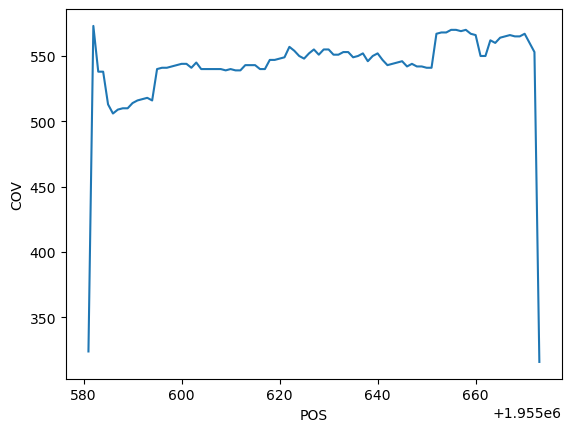

In [261]:
sns.lineplot(data=df_depth.query("POS >= 1955581 & POS <= 1955673"),
             x='POS',
             y='COV'
            )

In [316]:
df_lowAF_variants.query("longitudinal_patient==1").head(20)

,pid,SampleID,POS,REF,ALT,QUAL,FILTER,DP,RO,AO,...,Coll2014,Lineage,high_F2,longitudinal_patient,SRP_prob,SAP_prob,Original_ID,patient_num,sampling_week,Personal_Ref_Aln
26,T0002,MFS-509,336400,CAGCGA,GAGGGG,0.000000e+00,NaN,442,279,163,...,4.8,4,0,1,5.566087e-02,0.129263,S0002-01,2,1,0
27,T0002,MFS-509,1416222,A,G,0.000000e+00,NaN,427,348,79,...,4.8,4,0,1,3.772845e-01,0.232475,S0002-01,2,1,0
28,T0002,MFS-509,1416232,ACA,GCC,2.128760e-13,NaN,439,358,81,...,4.8,4,0,1,3.802638e-01,0.303265,S0002-01,2,1,0
29,T0002,MFS-509,1480174,CAG,GAT,0.000000e+00,NaN,314,272,42,...,4.8,4,0,1,5.356363e-10,0.152038,S0002-01,2,1,0
30,T0002,MFS-509,1480184,GGCGCC,AGTGCG,6.015020e-14,NaN,297,259,38,...,4.8,4,0,1,2.854565e-10,0.075180,S0002-01,2,1,0
31,T0002,MFS-509,1480195,GCGT,TCCC,9.450430e-14,NaN,316,278,38,...,4.8,4,0,1,3.874003e-10,0.134131,S0002-01,2,1,0
32,T0002,MFS-509,1480204,CG,TA,0.000000e+00,NaN,330,292,38,...,4.8,4,0,1,1.135168e-04,0.134131,S0002-01,2,1,0
33,T0002,MFS-509,1480219,C,T,1.194560e-13,NaN,377,314,63,...,4.8,4,0,1,3.171246e-04,0.338905,S0002-01,2,1,0
34,T0002,MFS-509,1480231,GAA,CAC,0.000000e+00,NaN,353,289,64,...,4.8,4,0,1,1.094410e-02,0.162326,S0002-01,2,1,0
35,T0002,MFS-509,2631565,T,C,2.420460e-13,NaN,615,357,257,...,4.8,4,0,1,7.995580e-05,0.077089,S0002-01,2,1,0


In [346]:
SNP_window_size

25

768 high-density SNP sites across 15 genes/regions: ['PPE9' 'mce2C' 'purF' 'Rv1230c' 'embR' 'Rv1318c' 'PPE21' 'polA' 'NC_1473'
 'Rv1888A' 'PPE40' 'bkdC' 'moaA1' 'PPE53' 'PPE64']


In [311]:
df_test = df_lowAF_variants.query("SampleID==@sample")[['POS', 'REF', 'ALT', 'DP', 'RO', 'AO', 'AF', 'GENE', 'EFFECT']]
df_test.loc[(df_test['POS'].isin(low_quality_variant_sites)) | (df_test['POS'].isin(high_density_SNP_sites)), 'LOW_QC'] = 1
df_test['LOW_QC'] = df_test['LOW_QC'].fillna(0).astype(int)
df_test['LOW_QC'].value_counts()

LOW_QC
1    12
0     7
Name: count, dtype: int64

In [312]:
df_test.query("LOW_QC==1")

,POS,REF,ALT,DP,RO,AO,AF,GENE,EFFECT,LOW_QC
100,1480174,CAG,GAT,325,284,41,0.126154,Rv1318c,missense_variant,1
101,1480195,GCGT,TCCC,304,268,36,0.118421,Rv1318c,missense_variant,1
102,1480204,CG,TA,325,289,36,0.110769,Rv1318c,missense_variant,1
103,1480219,C,T,344,291,53,0.154070,Rv1318c,synonymous_variant,1
104,1480231,GAA,CAC,340,287,53,0.155882,Rv1318c,missense_variant,1
105,1480242,AT,GA,343,301,42,0.122449,Rv1318c,synonymous_variant,1
107,1955581,A,C,289,264,25,0.086505,Rv1729c-Rv1730c,intergenic_region,1
110,2266550,GCCC,TCCG,378,277,101,0.267196,Rv2020c,synonymous_variant,1
113,3478272,G,A,453,429,24,0.052980,moaA1,synonymous_variant,1
114,3478467,C,T,481,390,91,0.189189,moaA1,synonymous_variant,1


In [313]:
df_test.query("LOW_QC==0")

,POS,REF,ALT,DP,RO,AO,AF,GENE,EFFECT,LOW_QC
99,968426,A,AGCCGGGTTG,148,39,105,0.709459,PE_PGRS15,conservative_inframe_insertion,0
106,1583717,T,G,247,234,13,0.052632,fmu,missense_variant,0
108,2076862,A,G,264,243,21,0.079545,gcvB,missense_variant,0
109,2133468,T,TTCGCATGCCGTCACC,124,56,55,0.443548,Rv1883c,disruptive_inframe_insertion,0
111,2724180,TCACGATCGGGTCTCCTCTAG,T,146,51,95,0.650685,Rv2426c,conservative_inframe_deletion,0
112,3131469,T,TTGTCGGCGA,190,49,137,0.721053,Rv2823c,conservative_inframe_insertion,0
117,4314991,CG,C,324,306,17,0.052469,glpQ1,frameshift_variant,0


In [301]:
h37Rv_genes.query("Symbol=='PPE53'")

,Gene_Ind,Feature,Start,End,Strand,Frame,H37rv_GeneID,Symbol,Function,Product,...,SWISS-MODEL,Orthologues M. leprae,Orthologues M. marinum,Orthologues M. smegmatis,Orthologues M. bovis,Orthologues M. lepromatosis,Orthologues M. tuberculosis,Orthologues M. abscessus,Orthologues M. haemophilum,Orthologues M. orygis
3247,3247,CDS,3527391,3529163,-,0.0,Rv3159c,PPE53,Function unknown,PPE family protein PPE53,...,Q6MX04,NaN,MMAR_1469,NaN,Mb3183c,NaN,NaN,NaN,NaN,NaN


In [305]:
df_SNPs.query("POS >= 3527391 & POS <= 3529163").query("SNP_density_rolling_avg > 0.1").sort_values("SNP_density_rolling_avg")

,POS,SNP,REGION,SNP_density_rolling_avg
3528083,3528084,1,PPE53,0.12
3528084,3528085,0,PPE53,0.12
3528085,3528086,0,PPE53,0.12
3528086,3528087,0,PPE53,0.12
3528087,3528088,0,PPE53,0.12


In [309]:
df_SNPs.query("POS > 3528088").head(20)

,POS,SNP,REGION,SNP_density_rolling_avg
3528088,3528089,0,PPE53,0.08
3528089,3528090,0,PPE53,0.08
3528090,3528091,0,PPE53,0.08
3528091,3528092,0,PPE53,0.08
3528092,3528093,0,PPE53,0.08
3528093,3528094,0,PPE53,0.08
3528094,3528095,0,PPE53,0.08
3528095,3528096,0,PPE53,0.08
3528096,3528097,0,PPE53,0.04
3528097,3528098,0,PPE53,0.04


In [307]:
high_density_SNP_sites

array([ 467540,  467541,  467542,  467543,  467544,  467545,  467546,
        467547,  467548,  467549,  467550,  467551,  467552,  467553,
        467554,  467555,  467556,  467557,  467558,  467559,  467560,
        467561,  467562,  467563,  467564,  467565,  467566,  467567,
        467568,  467569,  467570, 1480171, 1480172, 1480173, 1480174,
       1480175, 1480176, 1480177, 1480178, 1480179, 1480180, 1480181,
       1480182, 1480183, 1480184, 1480185, 1480186, 1480187, 1480188,
       1480189, 1480190, 1480191, 1480192, 1480193, 1480194, 1480195,
       1480196, 1480197, 1480198, 1480199, 1480200, 1480201, 1480202,
       1480203, 1480204, 1480205, 1480206, 1480207, 1480208, 1480209,
       1480210, 1480211, 1480212, 1480213, 1480214, 1480215, 1480216,
       1480217, 1480218, 1480219, 1480220, 1480221, 1480222, 1480223,
       1480224, 1480225, 1480226, 1480227, 1480228, 1480229, 1480230,
       1480231, 1480232, 1480233, 1480234, 1480235, 1480236, 1480237,
       1480238, 1480

In [306]:
3528088+25

3528113

In [203]:
df_variants.query("POS==968426").SampleID.nunique()

725

In [207]:
df_variants.query("POS==968426")[['pid', 'SampleID', 'POS', 'REF', 'ALT', 'AF']].sort_values("AF")

,pid,SampleID,POS,REF,ALT,AF
379745,T0295,MFS-284,968426,A,AGCCGGGTTG,0.628788
453138,T0288,MFS-306,968426,A,AGCCGGGTTG,0.646552
1105497,T0100,MFS-55,968426,A,AGCCGGGTTG,0.652174
488293,T0311,MFS-317,968426,A,AGCCGGGTTG,0.652482
1921675,T0170,MFS-88,968426,A,AGCCGGGTTG,0.652893
...,...,...,...,...,...,...
1395193,T0392,MFS-669,968426,A,AGCCGGGTTG,0.869863
1377289,T0301,MFS-656,968426,A,AGCCGGGTTG,0.869955
1181171,T0121,MFS-585,968426,A,AGCCGGGTTG,0.874126
923379,T0368,MFS-458,968426,A,AGCCGGGTTG,0.879032


In [208]:
725/733

0.9890859481582538

In [200]:
df_variants.query("POS==968426 & REF.str.len() == ALT.str.len()")

,pid,SampleID,POS,REF,ALT,QUAL,FILTER,DP,RO,AO,...,EFFECT,HGVS_C,HGVS_P,F2,Coll2014,Lineage,high_F2,longitudinal_patient,SRP_prob,SAP_prob
1040096,T0017,MFS-520,968426,A,G,7441.68,NaN,245,0,245,...,stop_lost&splice_region_variant,c.1819T>C,p.Ter607Glnext*?,0.019246,1.1.2,1,0,0,NaN,0.27722


In [201]:
df_TRUST_pids_samples.query("pid=='T0017'")

,pid,Original_ID,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lineage,Culture_Mixed_Infection,Freschi_Lineage_1,Freschi_Lineage_2,Lipworth2019,Shitikov2017,Stucki2016,patient_num,sampling_week
398,T0017,S0017-01,MFS-520,0.42,299.818182,306.0,99.068895,98.947078,0.019246,1.1.2,1.1.2,1,0,1.1.2,NaN,"indo_oceanic,mungi",NaN,NaN,17,1


In [180]:
high_density_SNP_regions.query("POS > 1480170 & POS < 1480300").sort_values("POS")

,POS,SNP,SNP_density_rolling_avg,REGION
1480194,1480195,1,0.12,Rv1318c
1480195,1480196,0,0.12,Rv1318c
1480196,1480197,0,0.12,Rv1318c
1480197,1480198,0,0.12,Rv1318c
1480203,1480204,1,0.12,Rv1318c
1480204,1480205,0,0.12,Rv1318c
1480205,1480206,0,0.12,Rv1318c
1480206,1480207,0,0.12,Rv1318c
1480207,1480208,0,0.12,Rv1318c
1480218,1480219,1,0.12,Rv1318c


In [185]:
df_SNPs.query("POS >= 1480174 & POS < 1480245").sort_values("POS")

,POS,SNP,SNP_density_rolling_avg,REGION
1480173,1480174,1,0.04,Rv1318c
1480174,1480175,0,0.04,Rv1318c
1480175,1480176,0,0.04,Rv1318c
1480176,1480177,0,0.04,Rv1318c
1480177,1480178,0,0.04,Rv1318c
...,...,...,...,...
1480239,1480240,0,0.08,Rv1318c
1480240,1480241,0,0.08,Rv1318c
1480241,1480242,1,0.12,Rv1318c
1480242,1480243,0,0.12,Rv1318c


In [181]:
df_SNPs.query("POS==1480174")

,POS,SNP,SNP_density_rolling_avg,REGION
1480173,1480174,1,0.04,Rv1318c


In [55]:
deriv_threshold

0.14619883040935644

In [59]:
1480714 in low_quality_variant_sites

True

In [ ]:
1480174

In [62]:
df_depth.query("POS==1480147")

,POS,COV,COV_ROLLING_AVG,NORM_COV_COV_ROLLING_AVG,DERIV_NORM_COV_COV_ROLLING_AVG,REGION,EDGE
1480146,1480147,508,351.64,1.444659,0.439663,Rv1318c,JUMP


In [65]:
df_depth.query("POS==1480174")

,POS,COV,COV_ROLLING_AVG,NORM_COV_COV_ROLLING_AVG,DERIV_NORM_COV_COV_ROLLING_AVG,REGION,EDGE
1480173,1480174,423,442.3,0.956364,-0.109975,Rv1318c,NaN


In [64]:
df_candidate_regions.query("START==1480147")

,START,END,AVG_COV_INTERVENING,MAX_DERIV_INTERVENING,COV_ROLLING_AVG_BEFORE,COV_ROLLING_AVG_AFTER


In [61]:
df_candidate_regions.query("START > 1480100")

,START,END,AVG_COV_INTERVENING,MAX_DERIV_INTERVENING,COV_ROLLING_AVG_BEFORE,COV_ROLLING_AVG_AFTER
124,1480714,1480740,445.500000,0.067705,303.12,304.52
125,1487985,1488077,187.521739,0.044019,154.50,57.16
126,1488124,1488126,69.000000,0.123512,62.42,108.80
127,1488410,1488464,138.759259,0.051163,103.50,119.06
128,1510307,1510315,338.250000,0.048449,289.62,285.16
...,...,...,...,...,...,...
415,4300677,4300685,439.375000,0.097524,396.42,375.02
416,4348725,4348824,508.979798,0.046109,321.94,312.28
417,4359130,4359182,356.076923,0.071834,254.80,322.66
418,4365278,4365286,501.875000,0.023930,392.10,432.14


In [52]:
df_test.query("LOW_QC==0")

,POS,REF,ALT,DP,RO,AO,AF,GENE,EFFECT,LOW_QC
99,968426,A,AGCCGGGTTG,148,39,105,0.709459,PE_PGRS15,conservative_inframe_insertion,0
100,1480174,CAG,GAT,325,284,41,0.126154,Rv1318c,missense_variant,0
101,1480195,GCGT,TCCC,304,268,36,0.118421,Rv1318c,missense_variant,0
102,1480204,CG,TA,325,289,36,0.110769,Rv1318c,missense_variant,0
103,1480219,C,T,344,291,53,0.154070,Rv1318c,synonymous_variant,0
104,1480231,GAA,CAC,340,287,53,0.155882,Rv1318c,missense_variant,0
105,1480242,AT,GA,343,301,42,0.122449,Rv1318c,synonymous_variant,0
106,1583717,T,G,247,234,13,0.052632,fmu,missense_variant,0
107,1955581,A,C,289,264,25,0.086505,Rv1729c-Rv1730c,intergenic_region,0
108,2076862,A,G,264,243,21,0.079545,gcvB,missense_variant,0


In [ ]:
z

In [48]:
df_lowAF_variants.query("SampleID == @sample & Personal_Ref_Aln==1")[['POS', 'REF', 'ALT', 'DP', 'RO', 'AO', 'AF', 'GENE', 'HGVS_C', 'HGVS_P']]

,POS,REF,ALT,DP,RO,AO,AF,GENE,HGVS_C,HGVS_P
99,968426,A,AGCCGGGTTG,148,39,105,0.709459,PE_PGRS15,c.1810_1818dupCAACCCGGC,p.Gly606_Ter607insGlnProGly
100,1480174,CAG,GAT,325,284,41,0.126154,Rv1318c,c.649_651delCTGinsATC,p.Leu217Ile
101,1480195,GCGT,TCCC,304,268,36,0.118421,Rv1318c,c.627_630delACGCinsGGGA,p.Arg210Gly
102,1480204,CG,TA,325,289,36,0.110769,Rv1318c,c.620_621delCGinsTA,p.Pro207Leu
103,1480219,C,T,344,291,53,0.154070,Rv1318c,c.606G>A,p.Ala202Ala
104,1480231,GAA,CAC,340,287,53,0.155882,Rv1318c,c.592_594delTTCinsGTG,p.Phe198Val
105,1480242,AT,GA,343,301,42,0.122449,Rv1318c,c.582_583delATinsTC,p.196
106,1583717,T,G,247,234,13,0.052632,fmu,c.617T>G,p.Val206Gly
107,1955581,A,C,289,264,25,0.086505,Rv1729c-Rv1730c,n.1955581A>C,NaN
108,2076862,A,G,264,243,21,0.079545,gcvB,c.986A>G,p.Lys329Arg


In [84]:
df_test.LOW_QC.value_counts()

LOW_QC
0    10
1     7
Name: count, dtype: int64

In [80]:
df_test.query("LOW_QC==1")

,POS,REF,ALT,DP,RO,AO,GENE,EFFECT,LOW_QC
64,1480174,CAG,GAT,339,303,36,Rv1318c,missense_variant,1
71,1955581,A,C,349,317,32,Rv1729c-Rv1730c,intergenic_region,1
76,3478467,C,T,461,368,93,moaA1,synonymous_variant,1
80,4359183,T,G,238,222,16,espK,synonymous_variant,1


In [314]:
sample = 'MFS-509'
window_size = 50
depth_file = f'/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_processed/{sample}/bam/{sample}.depth.tsv.gz'
df_depth = compute_coverage_derivative(depth_file, window_size)

low_quality_variant_sites = get_candidate_coverage_plateaus(df_depth)

EDGE
DROP    2252
JUMP    2159
Name: count, dtype: int64
Keeping 845 / 845 candidate plateaus


In [315]:
df_lowAF_variants.query("SampleID == @sample & POS in @low_quality_variant_sites")[['POS', 'REF', 'ALT', 'DP', 'RO', 'AO', 'GENE', 'EFFECT']]

,POS,REF,ALT,DP,RO,AO,GENE,EFFECT
26,336400,CAGCGA,GAGGGG,442,279,163,PE_PGRS3-PE_PGRS4,intergenic_region
29,1480174,CAG,GAT,314,272,42,Rv1318c,missense_variant
32,1480204,CG,TA,330,292,38,Rv1318c,missense_variant
33,1480219,C,T,377,314,63,Rv1318c,synonymous_variant
34,1480231,GAA,CAC,353,289,64,Rv1318c,missense_variant
35,2631565,T,C,615,357,257,plcA,missense_variant
36,2631743,GCACT,ACACG,413,363,49,plcA,missense_variant
37,2631755,C,G,442,391,50,plcA,synonymous_variant
38,2631761,G,C,445,396,49,plcA,synonymous_variant
39,2631779,C,G,407,375,32,plcA,missense_variant


In [311]:
df_lowAF_variants.query("SampleID == @sample & POS in @exclude_sites")[['POS', 'REF', 'ALT', 'DP', 'RO', 'AO', 'GENE', 'EFFECT']]

,POS,REF,ALT,DP,RO,AO,GENE,EFFECT
64,1480174,CAG,GAT,339,303,36,Rv1318c,missense_variant
71,1955581,A,C,349,317,32,Rv1729c-Rv1730c,intergenic_region
76,3478467,C,T,461,368,93,moaA1,synonymous_variant
77,3528117,TAGA,CATG,422,313,109,PPE53,missense_variant
78,3528140,GCGCG,ACGCA,448,322,126,PPE53,synonymous_variant
80,4359183,T,G,238,222,16,espK,synonymous_variant


In [290]:
df_lowAF_variants.query("SampleID == @sample & GENE.str.contains('esp')")

,pid,SampleID,POS,REF,ALT,QUAL,FILTER,DP,RO,AO,...,F2,Coll2014,Lineage,high_F2,longitudinal_patient,SRP_prob,SAP_prob,Original_ID,patient_num,sampling_week
80,T0003,MFS-511,4359183,T,G,0.0,NaN,238,222,16,...,0.009607,2.2.1,2,0,1,0.321554,0.441248,S0003-01,3,1


In [148]:
exclude_BED = pd.read_csv("~/Mtb_Megapipe/references/ref_genome/RLC_Regions.Plus.LowPmapK50E4.H37Rv.bed", sep='\t', header=None)
exclude_BED = pd.read_csv("~/Mtb_Megapipe/references/ref_genome/RLC_regions_Marin_2022.bed", sep='\t', header=None)
exclude_BED_sites = []

for i, row in exclude_BED.iterrows():
    # np.arange will make the upper bound exclusive. Note that these are exclude indices though, so have to add 1 to get the positions in natural coordinates
    exclude_indices = np.arange(row[1], row[2])
    exclude_BED_sites += list(exclude_indices + 1)

exclude_BED_sites = np.unique(exclude_BED_sites)
len(exclude_BED_sites), len(exclude_BED_sites) / len(df_depth)

(177077, 0.0401395705618819)

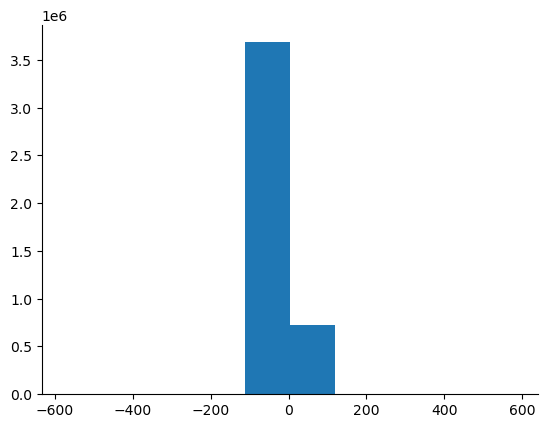

In [150]:
deriv_col = 'DERIV_DIFF_COV_COV_ROLLING_AVG'
plt.hist(df_depth[deriv_col])
sns.despine()
plt.show()

In [152]:
# get sites with a likely deletion. Exclude low empirical base pair recall or low k-mer mappability so that we don't overcall deletions.
deletion_sites = df_depth.query("POS not in @exclude_BED_sites & EDGE=='DROP' & COV < 100").POS.values

# then remove the positions directly after because those are positions where the coverage has "recovered", so their derivative will be very high
post_deletion_sites = deletion_sites + 1

In [164]:
# exclude regions with low EBPR or low k-mer mappability
df_candidate_regions = df_depth.dropna(subset='EDGE').query("POS not in @exclude_BED_sites & POS not in @deletion_sites & POS not in @post_deletion_sites").reset_index(drop=True)

cov_change_sites = df_candidate_regions.POS.values
# cov_change_types = df_candidate_regions.EDGE.values
# cov_values = df_candidate_regions.COV.values
# derivatives = df_candidate_regions[deriv_col].values

low_quality_bounds = []

for i, row in df_candidate_regions.iterrows():
    if i < len(df_candidate_regions) - 1:
        df_candidate_regions.loc[i, ['START', 'END']] = [row['POS'], cov_change_sites[i+1]-1]

# df_regions_to_exclude = pd.DataFrame(low_quality_bounds)
# df_regions_to_exclude.columns = ['START', 'END', 'EDGE', 'COV', 'DERIVATIVE']

# exclude intervals that have the same start and end, that's just a deletion
# exclude those with coverage < 20, also deletions
# df_regions_to_exclude = df_regions_to_exclude.query("START != END & COV > 20")
# df_regions_to_exclude['PRODUCT'] = df_regions_to_exclude['LENGTH'] * df_regions_to_exclude['DERIVATIVE'].abs()

In [165]:
# get all genes/regions with the jumps/drops, then exclude those entirely
# BUT ONLY AFTER EXCLUDING THE SITES THAT ARE DUE TO DELETIONS RELATIVE TO H37RV
# exclude any more deletions, which will be when START = END
df_regions_to_exclude = df_candidate_regions.dropna(subset='START').query("START != END")
df_regions_to_exclude[['START', 'END']] = df_regions_to_exclude[['START', 'END']].astype(int)
df_regions_to_exclude['LENGTH'] = df_regions_to_exclude['END'] - df_regions_to_exclude['START'] + 1

In [166]:
for i, row in df_regions_to_exclude.iterrows():

    start = row['START']
    end = row['END']

    # get the maximum derivative in the region, excluding the first site because it's derivative will be relative to the previous site, which is very different
    max_deriv = df_depth.query("POS > @start & POS <= @end")[deriv_col].abs().max()
    df_regions_to_exclude.loc[i, 'MAX_DERIV_INTERVENING'] = max_deriv

In [167]:
thresh = np.percentile(df_regions_to_exclude['MAX_DERIV_INTERVENING'], 25)
thresh

27.32000000000005

In [182]:
# next, get the average derivative within each candidate plateau. If the maximum absolute value of the derivative is too high, exclude that putative region
thresh = np.percentile(df_regions_to_exclude['MAX_DERIV_INTERVENING'], 25)
thresh = 20
df_final = df_regions_to_exclude.query("MAX_DERIV_INTERVENING < @thresh")

In [184]:
df_final

,POS,COV,COV_ROLLING_AVG,DIFF_COV_COV_ROLLING_AVG,DERIV_DIFF_COV_COV_ROLLING_AVG,REGION,EDGE,START,END,LENGTH,MAX_DERIV_INTERVENING
0,71585,492,294.34,197.66,227.72,NC_52,JUMP,71585,71586,2,3.30
3,336371,474,311.72,162.28,137.46,NC_226,JUMP,336371,336422,52,19.22
4,336423,310,482.66,-172.66,-159.58,NC_226,DROP,336423,336480,58,19.00
13,850536,442,303.16,138.84,212.04,NC_594,JUMP,850536,850539,4,19.80
30,1895651,433,273.54,159.46,223.66,NC_1295,JUMP,1895651,1895654,4,8.22
33,2221217,441,296.64,144.36,215.26,Rv1978,JUMP,2221217,2221223,7,13.72
51,3247870,204,276.76,-72.76,207.18,ppsA,JUMP,3247870,3247877,8,7.98
53,3415181,136,399.82,-263.82,-235.32,NC_2355,DROP,3415181,3415194,14,15.66
65,3760399,491,365.30,125.70,126.28,PPE56,JUMP,3760399,3760421,23,13.72
67,3820502,234,291.36,-57.36,-108.70,NC_2621,DROP,3820502,3820503,2,9.12


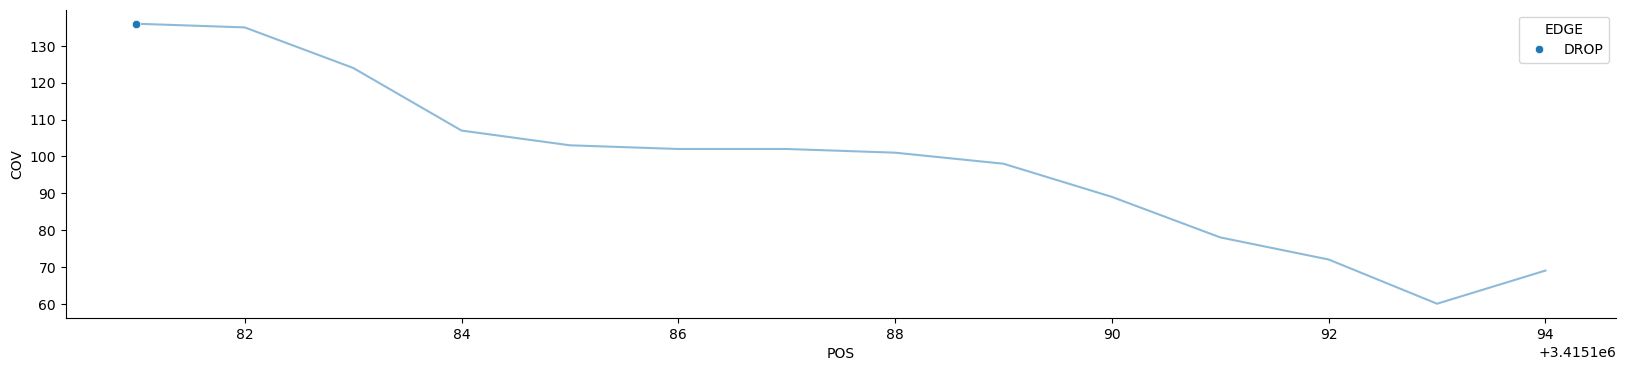

In [187]:
plot_min = 3415181
plot_max = 3415194

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(data=df_depth.query("POS >= @plot_min & POS <= @plot_max"),
             x='POS',
             y='COV',
             ax=ax,
             zorder=0,
             alpha=0.5
            )

sns.scatterplot(data=df_candidate_regions.query("POS >= @plot_min & POS <= @plot_max"),
                x='POS',
                y='COV',
                hue='EDGE'
               )

sns.despine()
plt.show()

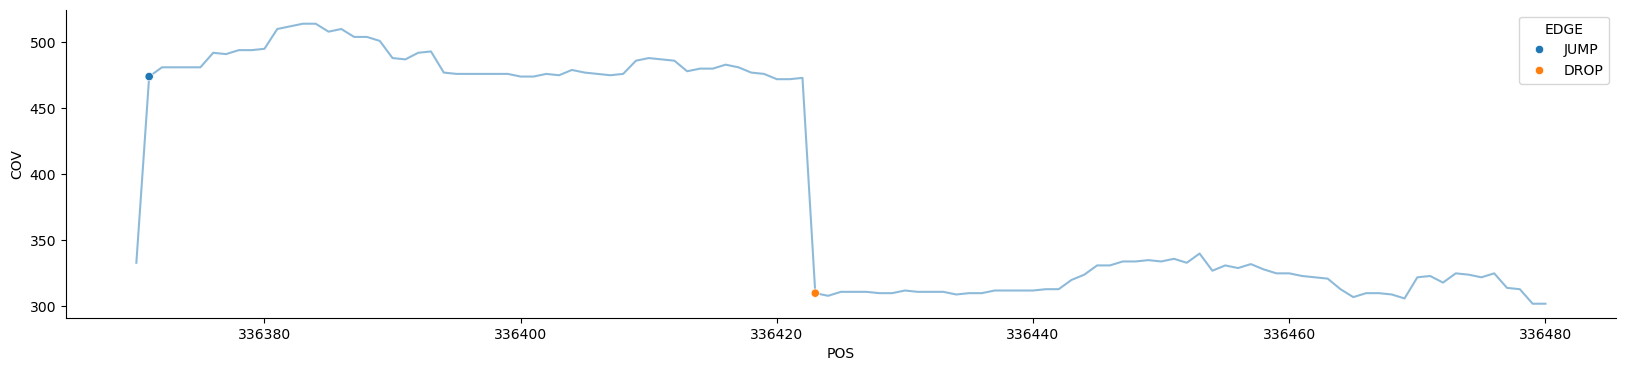

In [178]:
plot_min = 336370
plot_max = 336480

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(data=df_depth.query("POS >= @plot_min & POS <= @plot_max"),
             x='POS',
             y='COV',
             ax=ax,
             zorder=0,
             alpha=0.5
            )

sns.scatterplot(data=df_candidate_regions.query("POS >= @plot_min & POS <= @plot_max"),
                x='POS',
                y='COV',
                hue='EDGE'
               )

sns.despine()
plt.show()

In [174]:
df_candidate_regions

,POS,COV,COV_ROLLING_AVG,DIFF_COV_COV_ROLLING_AVG,DERIV_DIFF_COV_COV_ROLLING_AVG,REGION,EDGE,START,END
0,71585,492,294.34,197.66,227.72,NC_52,JUMP,71585.0,71586.0
1,71587,323,297.58,25.42,-168.94,NC_52,DROP,71587.0,279590.0
2,279591,187,3.82,183.18,179.26,NC_184,JUMP,279591.0,336370.0
3,336371,474,311.72,162.28,137.46,NC_226,JUMP,336371.0,336422.0
4,336423,310,482.66,-172.66,-159.58,NC_226,DROP,336423.0,336480.0
...,...,...,...,...,...,...,...,...,...
69,3896727,257,191.40,65.60,256.98,Rv3479,JUMP,3896727.0,4040944.0
70,4040945,159,308.08,-149.08,-111.34,NC_2766,DROP,4040945.0,4083323.0
71,4083324,162,314.92,-152.92,-136.32,Rv3645,DROP,4083324.0,4246584.0
72,4246585,292,208.38,83.62,103.88,embB,JUMP,4246585.0,4247023.0


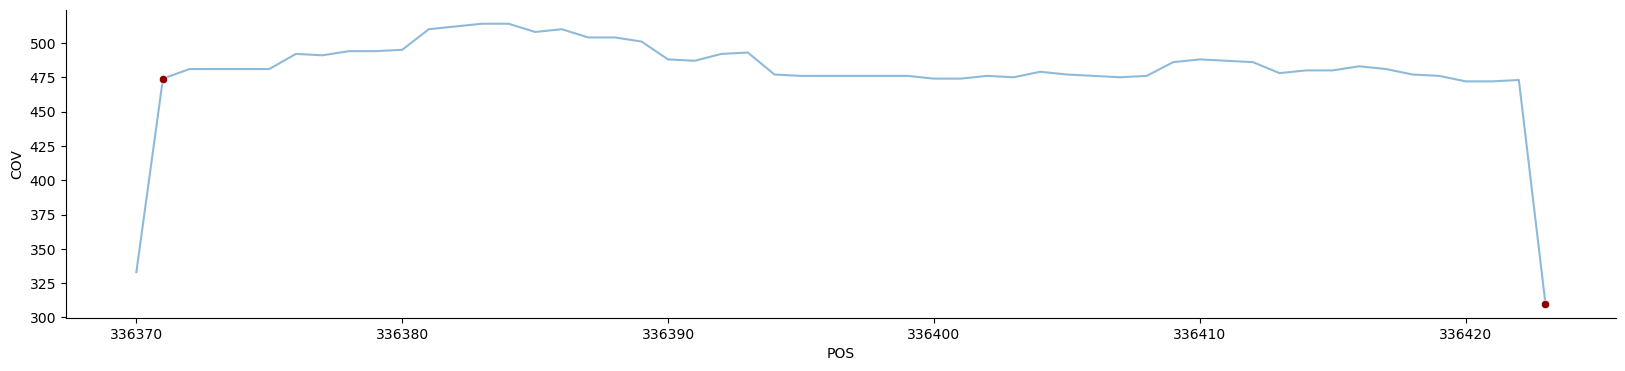

In [400]:
plot_min = 336370
plot_max = 336423

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(data=df_depth.query("POS >= @plot_min & POS <= @plot_max"),
             x='POS',
             y='COV',
             ax=ax,
             zorder=0,
             alpha=0.5
            )

sns.scatterplot(data=df_depth.dropna(subset='EDGE').query("POS >= @plot_min & POS <= @plot_max"),
                x='POS',
                y='COV',
                ax=ax,
                color='darkred',
                zorder=1
               )

sns.despine()
plt.show()

In [97]:
# top_sites_cov_changes = {}

# for i, sample in enumerate(df_TRUST_pids_samples.SampleID.values):

#     if sample not in top_sites_cov_changes.keys():
        
#         depth_file = f'/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_processed/{sample}/bam/{sample}.depth.tsv.gz'
        
#         if os.path.isfile(depth_file):
#             top_sites_cov_changes[sample] = find_large_coverage_changes(depth_file, window_size=50)

#     if i % 10 == 0:
#         print(i)

top_sites_cov_changes = pd.read_csv("top_sites_with_coverage_changes.csv")
top_sites_cov_changes_dict = dict(top_sites_cov_changes)

df_lowAF_variants['COV_change_site'] = df_lowAF_variants.apply(lambda row: row['POS'] in top_sites_cov_changes_dict.get(row['SampleID']).values, axis=1)

df_lowAF_variants.COV_change_site.value_counts()

COV_change_site
False    59118
True      5039
Name: count, dtype: int64

In [98]:
df_lowAF_variants.query("COV_change_site==False").high_F2.value_counts()

high_F2
0    44484
1    14634
Name: count, dtype: int64

In [104]:
df_lowAF_variants.query("COV_change_site==False & EFFECT != 'synonymous_variant' & F2 <= 0.1")[['pid', 'SampleID', 'POS', 'REF', 'ALT', 'GENE', 'EFFECT', 'DP', 'RO', 'AO', 'AF', 'Coll2014', 'Lineage', 'F2', 'sampling_week', 'longitudinal_patient']].query("longitudinal_patient==1").query("pid=='T0002'")

,pid,SampleID,POS,REF,ALT,GENE,EFFECT,DP,RO,AO,AF,Coll2014,Lineage,F2,sampling_week,longitudinal_patient
26,T0002,MFS-509,336400,CAGCGA,GAGGGG,PE_PGRS3-PE_PGRS4,intergenic_region,442,279,163,0.368778,4.8,4,0.006467,1,1
28,T0002,MFS-509,1416232,ACA,GCC,embR,missense_variant,439,358,81,0.184510,4.8,4,0.006467,1,1
29,T0002,MFS-509,1480174,CAG,GAT,Rv1318c,missense_variant,314,272,42,0.133758,4.8,4,0.006467,1,1
32,T0002,MFS-509,1480204,CG,TA,Rv1318c,missense_variant,330,292,38,0.115152,4.8,4,0.006467,1,1
34,T0002,MFS-509,1480231,GAA,CAC,Rv1318c,missense_variant,353,289,64,0.181303,4.8,4,0.006467,1,1
39,T0002,MFS-509,2631779,C,G,plcA,missense_variant,407,375,32,0.078624,4.8,4,0.006467,1,1
41,T0002,MFS-509,2631840,A,T,plcA,missense_variant,401,379,22,0.054863,4.8,4,0.006467,1,1
44,T0002,MFS-510,1416232,ACA,GCC,embR,missense_variant,354,283,71,0.200565,4.8,4,0.007872,5,1
45,T0002,MFS-510,1480174,CAG,GAT,Rv1318c,missense_variant,275,235,40,0.145455,4.8,4,0.007872,5,1
47,T0002,MFS-510,1480231,GAA,CAC,Rv1318c,missense_variant,292,238,54,0.184932,4.8,4,0.007872,5,1


# Align Reads to Personal Reference Genomes to mitigate reference bias-associated low frequency variants

In [ ]:
TRUST_isolates_copy_FQ

In [69]:
TRUST_isolates_copy_FQ = np.unique([os.path.basename(sample).split('_')[0] for sample in fNames])

In [75]:
pd.DataFrame({'A': TRUST_isolates_copy_FQ, 'B': TRUST_isolates_copy_FQ, 'C': 0}).to_csv("TRUST_isolates_copy_FQ.tsv", sep='\t', header=None, index=False)

In [13]:
fNames = glob.glob("/n/data1/hms/dbmi/farhat/fastq_db/TRUST_Illumina/Shipment5_Batch1/*.fastq.gz")
len(fNames)

254

In [21]:
assemblies = glob.glob("/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project/PacmanPipe_SM_Outputs/230902_TRUST_PB_Asm_V1/*/FlyeAssembly_I3_PilonPolishing/pilon_IllPE_Polishing_I3_Asm_ChangeSNPsINDELsOnly/*.fasta")

len(assemblies)

106

In [22]:
TRUST_PacBio_metadata = pd.read_csv("TRUST.PBAsm.ZA_106CI_AssemblySummary.csv")

# there's one sample, S0171-01, with a recorded circContig_Length of 0, but the contig is actually 4.4 Mbp, so keep it
keep_samples = TRUST_PacBio_metadata.query("NumContigs==1").SampleID.values
len(keep_samples)

93

In [23]:
TRUST_PacBio_metadata.query("NumContigs==1 & circContig_Length <= 4300000")

,SampleID,NumContigs,numContigs_Complete,circContig_Length,circContig_Cov,Flye_EstimatedCov,Flye_ReadLen_N50,Flye_ReadLen_N90,Lineage_Asm,Lineage_AsmPP,...,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_Asm,Dataset_Tag,PatientID,IsolateNum
87,S0171-01,1,0,0,0,47,3520,1670,lineage4.3.2.1,lineage4.3.2.1,...,0,0,0,0,0,0,lineage4,TRUST_PB_Set1,S0171,1


In [24]:
seq = [(seq.id, seq.seq) for seq in SeqIO.parse("/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project/PacmanPipe_SM_Outputs/230902_TRUST_PB_Asm_V1/S0171-01/FlyeAssembly_I3_PilonPolishing/pilon_IllPE_Polishing_I3_Asm_ChangeSNPsINDELsOnly/S0171-01.Flye.I3Asm.PilonPolished.fasta", "fasta")]

In [25]:
df_TRUST_pids_samples.query("Original_ID.str.contains('171')")

,pid,Original_ID,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lineage,Culture_Mixed_Infection,Freschi_Lineage_1,Freschi_Lineage_2,Lipworth2019,Shitikov2017,Stucki2016,patient_num,sampling_week
752,T0171,171-01,MFS-90,1.13,386.387197,394.0,98.988764,98.853142,0.008858,4.3.2.1,4.2.1.2.1.1.i1,4,0,4.2.1.2.1.1.i1,NaN,lam,NaN,4.3/LAM,171,1


In [26]:
len(seq), len(seq[0][1])

(1, 4417726)

In [27]:
keep_assemblies = [fName for fName in assemblies if os.path.basename(fName).split('.')[0] in keep_samples]
len(keep_assemblies)

93

In [14]:
keep_samples_dict = {}

for fName in assemblies:

    sample = os.path.basename(fName).split('.')[0]

    patient_num, sampling_week = sample.split('-')
    patient_num = int(float(patient_num.lstrip('S')))
    sampling_week = int(sampling_week)

    # check that there's at most 1 matching sample
    assert len(df_TRUST_pids_samples.query("patient_num==@patient_num & sampling_week==@sampling_week")) <= 1

    if len(df_TRUST_pids_samples.query("patient_num==@patient_num & sampling_week==@sampling_week")) == 1:
        MFS_ID = df_TRUST_pids_samples.query("patient_num==@patient_num & sampling_week==@sampling_week").SampleID.values[0]

        if not os.path.isdir(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly"):
            os.makedirs(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly")

        # only copy the FASTA file if it's a high-quality circular assembly
        if fName in keep_assemblies:
            if not os.path.isfile(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly/{MFS_ID}.fasta"):
                shutil.copy(fName, f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly/{MFS_ID}.fasta")
            keep_samples_dict[sample] = MFS_ID
        else:
            if os.path.isfile(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly/{MFS_ID}.fasta"):
                os.remove(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{MFS_ID}/assembly/{MFS_ID}.fasta")

In [31]:
df_personal_ref_assembly = pd.DataFrame(columns = ['SampleID', 'RefGenome', 'RefGenomeSample'])

for i, row in df_TRUST_pids_samples.query("Kraken_Unclassified_Percent <= 20").reset_index().iterrows():

    assembly_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{row['SampleID']}/assembly/{row['SampleID']}.fasta"

    if os.path.isfile(assembly_fName):
        df_personal_ref_assembly.loc[i, :] = [row['SampleID'], 
                                              assembly_fName,
                                              row['SampleID']
                                             ]

    else:
        patient_num = row['patient_num']
        
        # if the assembly for the exact sample is not available, then take another sample from the patient
        for other_sample in df_TRUST_pids_samples.query("patient_num==@patient_num").SampleID.values:

            assembly_fName = f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/{other_sample}/assembly/{other_sample}.fasta"

            if os.path.isfile(assembly_fName):
                df_personal_ref_assembly.loc[i, :] = [row['SampleID'], 
                                                      assembly_fName,
                                                      other_sample
                                                     ]
        
    # print(, row['sampling_week'])

In [33]:
df_personal_ref_assembly.query("SampleID != RefGenomeSample")

,SampleID,RefGenome,RefGenomeSample
18,MFS-115,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-116
33,MFS-129,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-130
65,MFS-158,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-159
81,MFS-172,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-173
110,MFS-25,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-26
170,MFS-311,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-310
172,MFS-313,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-314
176,MFS-317,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-318
240,MFS-377,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-113
242,MFS-381,/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitu...,MFS-136


In [19]:
check_samples = keep_samples_dict.values()

df_TRUST_pids_samples.query("Kraken_Unclassified_Percent > 20 & SampleID in @check_samples")

,pid,Original_ID,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lineage,Culture_Mixed_Infection,Freschi_Lineage_1,Freschi_Lineage_2,Lipworth2019,Shitikov2017,Stucki2016,patient_num,sampling_week


In [58]:
df_personal_ref_assembly.query("SampleID=='MFS-102'")

,SampleID,RefGenome,RefGenomeSample


In [56]:
df_TRUST_pids_samples.query("Original_ID.str.contains('184')")

,pid,Original_ID,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lineage,Culture_Mixed_Infection,Freschi_Lineage_1,Freschi_Lineage_2,Lipworth2019,Shitikov2017,Stucki2016,patient_num,sampling_week
4,T0184,184-01,MFS-102,0.91,276.773151,282.0,98.829024,98.696394,0.018669,4.1.1.3,4.1.i1.2.1,4,0,4.1.i1.2.1,NaN,xtype,NaN,4,184,1


In [51]:
glob.glob("/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/aln_personal_assembly/*/pilon/*")

[]

In [77]:
df_personal_ref_assembly[['SampleID', 'RefGenome']].to_csv("TRUST_isolates.tsv", sep='\t', header=None, index=False)